In [11]:
import pandas as pd
import catboost as cb
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [7]:
# https://towardsdatascience.com/unconventional-sentiment-analysis-bert-vs-catboost-90645f2437a9

In [53]:
%load_ext watermark

In [54]:
%watermark -p catboost,pandas,numpy,sklearn

catboost: 1.0.4
pandas  : 1.4.2
numpy   : 1.22.4
sklearn : 0.0



In [8]:
# Data downloaded from https://www.kaggle.com/datasets/farisdurrani/sentimentsearch

df=pd.concat([
    pd.read_csv("../data/farisdurrani/twitter_filtered.csv"),
    pd.read_csv("../data/farisdurrani/facebook_filtered.csv")
])

In [9]:
df = df.dropna(subset=['sentiment'], axis=0)

In [12]:
df['Target'] = df['sentiment'].apply(lambda x: 1 if x==0 else np.sign(x)+1).astype(int)
df.head()

,platform,bodyText,sentiment,date,country,Target
0,Twitter,@Kenichan I dived many times for the ball. Man...,0.4939,2009-04-06,NaN,2
1,Twitter,"@nationwideclass no, it's not behaving at all....",-0.4939,2009-04-06,NaN,0
2,Twitter,Need a hug,0.4767,2009-04-06,NaN,2
3,Twitter,@LOLTrish hey long time no see! Yes.. Rains a...,0.6208,2009-04-06,NaN,2
4,Twitter,@Tatiana_K nope they didn't have it,0.0000,2009-04-06,NaN,1


In [13]:
X_train, _X, y_train, _y = train_test_split(df['bodyText'], df['Target'], stratify=df['Target'], test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(_X, _y, stratify=_y, test_size=0.5)

In [18]:
X_val

105526                @lilgary take what back? Im lost  lol
392442    my throat is sore, my hair is a mess and i can...
477580    uploaded more photos pheww  www.mileymandyfan8...
160495                              Plz. I want Fun Ranch. 
86988     @graceamy I was being childish lol cos one of ...
                                ...                        
293470    Sytycd I love the ChBABE, but that didn't look...
519842    @Miss_Melbourne thank you for the #ff recco mu...
636815              @boxdog looks like the matrix in blue! 
476164    Watching never back down..threw powder in my b...
221148    Everyone gets to lay out by the pool except fo...
Name: bodyText, Length: 82089, dtype: object

In [20]:
train_pool = cb.Pool(
    data=X_train.to_frame('content'),
    label=y_train,
    text_features=['content']
)
valid_pool = cb.Pool(
    data=X_val.to_frame('content'), 
    label=y_val,
    text_features=['content']
)

In [45]:
model = cb.CatBoostClassifier(
    iterations = 500,
    learning_rate = 0.1,
    eval_metric="Accuracy",
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

In [46]:
model.fit(
        train_pool,
        eval_set=valid_pool,
        verbose=10,
        plot=True,
        use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4903656	test: 0.4901875	best: 0.4901875 (0)	total: 5.54s	remaining: 46m 6s
10:	learn: 0.5222808	test: 0.5222502	best: 0.5222502 (10)	total: 1m	remaining: 45m 10s
20:	learn: 0.5347627	test: 0.5343834	best: 0.5343834 (20)	total: 2m 4s	remaining: 47m 27s
30:	learn: 0.5463553	test: 0.5452618	best: 0.5452618 (30)	total: 2m 57s	remaining: 44m 46s
40:	learn: 0.6569901	test: 0.6558735	best: 0.6558735 (40)	total: 3m 53s	remaining: 43m 37s
50:	learn: 0.6830229	test: 0.6824057	best: 0.6824057 (50)	total: 4m 53s	remaining: 43m 3s
60:	learn: 0.6965236	test: 0.6968900	best: 0.6968900 (60)	total: 5m 47s	remaining: 41m 43s
70:	learn: 0.7183155	test: 0.7188052	best: 0.7188052 (70)	total: 6m 48s	remaining: 41m 6s
80:	learn: 0.7291681	test: 0.7299882	best: 0.7299882 (80)	total: 7m 43s	remaining: 39m 55s
90:	learn: 0.7396613	test: 0.7404890	best: 0.7404890 (90)	total: 8m 36s	remaining: 38m 42s
100:	learn: 0.7469598	test: 0.7479078	best: 0.7489067 (99)	total: 9m 34s	remaining: 37m 48s
110:	lear

In [47]:
test_pool = cb.Pool(
    data=X_test.to_frame('content'), 
    label=y_test,
    text_features=['content']
)
y_hat = model.predict(test_pool)

<AxesSubplot:>

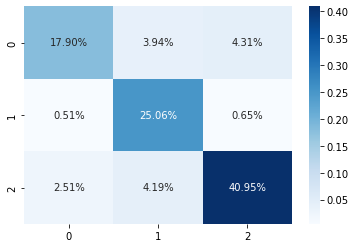

In [48]:
cf_matrix = confusion_matrix(y_test, y_hat)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [49]:
model.predict_proba(["I will never go back to this place"])

array([0.16020057, 0.63135258, 0.20844686])

In [50]:
model.predict_proba(["This place is a scam, i highly disrecommend"])

array([0.18762034, 0.5675432 , 0.24483646])

In [51]:
model.predict_proba(["no, it's not allright to say such things"])

array([0.68571312, 0.1558603 , 0.15842659])

In [52]:
model.predict_proba(["I really love this ring, it's so beautiful !"])

array([0.01407426, 0.00883489, 0.97709085])